In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 

In [4]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [20]:
colors_by_method = {}
baseline_methods = ['random','greedy','whittle_activity']
offline_methods = ['offline_solution','offline_solution_swaps','more_patients_than_providers']
online_methods = []

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(offline_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(online_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(offline_methods):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(online_methods):
    colors_by_method[m] = wistia[i]
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

In [8]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(baseline_methods+offline_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

# ML4H Plots

## Performance Comparison

/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])


Biparitte < group p 0.007756846915307087
Biparitte < group p 0.0002528480473506412
Biparitte < group p 0.0005562328747736323
Biparitte < group p 0.2878749861924432
Biparitte < group p 0.7089145712915501


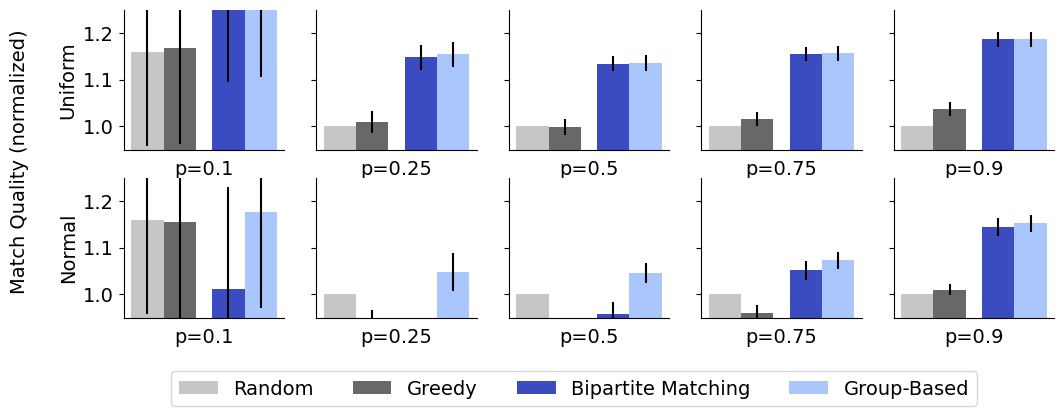

In [9]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps']
nice_names = ["Random","Greedy","Bipartite Matching","Group-Based"]
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 10, 'num_patients': 25, 'num_providers': 25}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "policy_comparison"
            
            temp_params = deepcopy(baseline_params)
            results = get_results_matching_parameters(dataset,"",temp_params)

            if k == 0:
                greedy_values = list(np.array([i['greedy_utilities'] for i in results]).flatten())
                random_values = list(np.array([i['random_utilities'] for i in results]).flatten())
                bipartite_values = list(np.array([i['offline_solution_utilities'] for i in results]).flatten())
                group_values = list(np.array([i['offline_solution_swaps_utilities'] for i in results]).flatten())

                p_vals = [stats.ttest_ind(greedy_values,group_values).pvalue,stats.ttest_ind(random_values,group_values).pvalue]
                # print("Group > All Policies p<",max(p_vals))

                if func == "normal":
                    p_val = stats.ttest_ind(bipartite_values,group_values).pvalue 
                    print("Biparitte < group p {}".format(p_val))

            num_data = 0
            if len(results)>0:
                num_data = len(results)
            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                
                if k ==0:
                    greedy_values = results['greedy_utilities'][0]
                    random_values = results['random_utilities'][0]
                    bipartite_values = results['offline_solution_utilities'][0]
                    group_values = results['offline_solution_swaps_utilities'][0]

                    # if func == 'uniform':
                    #     print("Policies are within {}".format(bipartite_values/group_values))
                    # print("For {} func, group vs. greedy {}".format(func,group_values/greedy_values))
                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/utility_comparison.pdf",dpi=300, bbox_inches='tight')


### Number of Patients and Providers

/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])


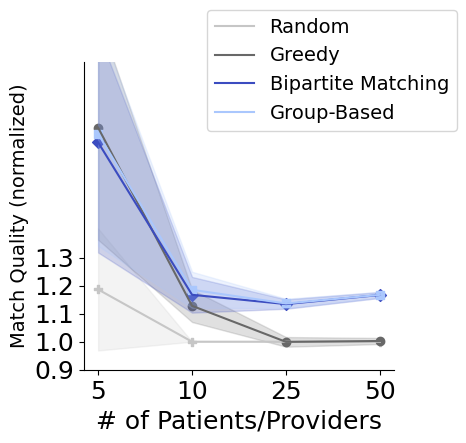

In [11]:
plt.figure(figsize=(4,4))

method_names = ['random','greedy','offline_solution','offline_solution_swaps']
nice_names = ["Random","Greedy","Bipartite Matching","Group-Based"]
width = 0.1
n_patients = [5,10,25,50]

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 10, 'top_choice_prob': 0.5, 'utility_function': 'uniform'}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)
for k,m in enumerate(method_names):
    scores = []
    stds = []

    for i,n in enumerate(n_patients):
        baseline_params['num_patients'] = n
        baseline_params['num_providers'] = n
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)

        if k == 0:
            greedy_values = list(np.array([i['greedy_utilities'] for i in results]).flatten())
            random_values = list(np.array([i['random_utilities'] for i in results]).flatten())
            bipartite_values = list(np.array([i['offline_solution_utilities'] for i in results]).flatten())
            group_values = list(np.array([i['offline_solution_swaps_utilities'] for i in results]).flatten())

            p_val = stats.ttest_ind(greedy_values,bipartite_values)
            # print("n {}, p val {}".format(n,p_val))
            # print(np.mean(bipartite_values)/np.mean(greedy_values))

        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            scores.append(results['{}_utilities'.format(m)][0])
            stds.append(results['{}_utilities'.format(m)][1]/(num_data**.5))        

    plt.plot(list(range(len(n_patients))),scores,color=colors_by_method[m],label=nice_names[k])
    plt.scatter(list(range(len(n_patients))),scores,color=colors_by_method[m],marker=shapes_by_method[m])
    plt.fill_between(list(range(len(n_patients))),np.array(scores) - np.array(stds),np.array(scores) + np.array(stds), alpha=0.2,  color=colors_by_method[m])

plt.xticks(list(range(len(n_patients))),n_patients)
plt.ylim([0.9,2])
plt.yticks([0.9,1,1.1,1.2,1.3])
plt.legend(loc='upper center',ncol=1,bbox_to_anchor=(0.8,1.2),fontsize=14)
plt.xlabel("# of Patients/Providers")
plt.ylabel("Match Quality (normalized)",fontsize=14,x=0.03)
plt.savefig("../../results/figures/equal_patients_providers.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])


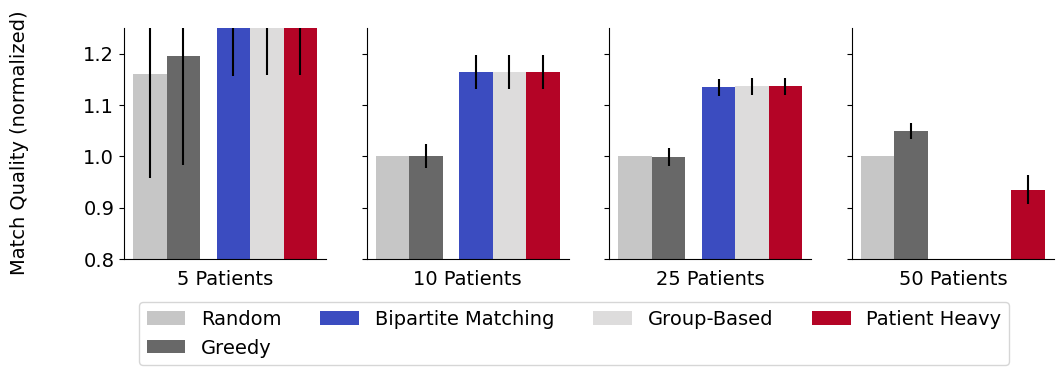

In [33]:
fig, axs = plt.subplots(1,4, figsize=(12, 3))
method_names = ['random','greedy','offline_solution','offline_solution_swaps','more_patients_than_providers']
nice_names = ["Random","Greedy","Bipartite Matching","Group-Based","Patient Heavy"]
width = 0.1
n_patients = [5,10,25,50]

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 10, 'top_choice_prob': 0.5, 'utility_function': 'uniform', 'num_providers': 25}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_patients):
    max_val = 0
    min_val = 1
    baseline_params['num_patients'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
        
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

    axs[i].set_xticks([])
    axs[i].set_yticks([0.8,0.9,1,1.1,1.2])

    if i == 0:
        axs[i].tick_params(axis='both', which='major', labelsize=14)
    else:
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

    axs[i].set_ylim([0.8,1.25])
    axs[i].set_xlabel("{} Patients".format(n),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_patients.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])
/usr0/home/naveenr/projects/patient_provider/patient/utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  data_point[key] = np.where(avg_by_type[data_type] == 0, 5, data_point[key] / avg_by_type[data_type])


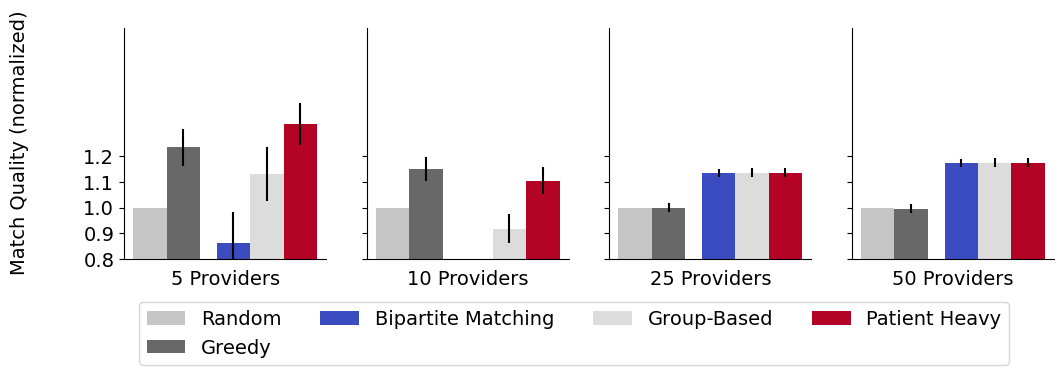

In [32]:
fig, axs = plt.subplots(1,4, figsize=(12, 3))
method_names = ['random','greedy','offline_solution','offline_solution_swaps','more_patients_than_providers']
nice_names = ["Random","Greedy","Bipartite Matching","Group-Based","Patient Heavy"]
width = 0.1
n_providers = [5,10,25,50]

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 10, 'top_choice_prob': 0.5, 'utility_function': 'uniform', 'num_patients': 25}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,n in enumerate(n_providers):
    max_val = 0
    min_val = 1
    baseline_params['num_providers'] = n
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "policy_comparison"
        
        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
        
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

    axs[i].set_xticks([])
    axs[i].set_yticks([0.8,0.9,1,1.1,1.2])

    if i == 0:
        axs[i].tick_params(axis='both', which='major', labelsize=14)
    else:
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

    axs[i].set_ylim([0.8,1.7])
    axs[i].set_xlabel("{} Providers".format(n),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/n_providers.pdf",dpi=300, bbox_inches='tight')
